# Library

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Problem 1

### 1-1

activation function, loss function

In [2]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    epsilon = 1e-12  # Avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    return -np.mean(np.log(y_pred[np.arange(len(y_true)), y_true]))

Forward, backward pass and evaluate accuracy

In [3]:
def forward(x, weights, biases):
    zs, activations = [], [x]
    for i in range(len(weights)):
        z = np.dot(activations[-1], weights[i]) + biases[i]
        zs.append(z)

        if i < len(weights) -1:
            a = relu(z)
        else:
            a = softmax(z)
        activations.append(a)
    return zs, activations

def backward(x, y_true, zs, activations, weights, biases, learning_rate):
    L = len(weights)
    batch_size = x.shape[0]
    
    grads_w = [None] * L
    grads_b = [None] * L

    y_pred = activations[-1]
    delta = y_pred.copy()
    delta[np.arange(batch_size), y_true] -= 1
    delta /= batch_size
    
    grads_w[-1] = np.dot(activations[L-1].T, delta)
    grads_b[-1] = np.sum(delta, axis=0, keepdims=True)

    for l in range(L-2, -1, -1):
        delta = np.dot(delta, weights[l+1].T) * relu_derivative(zs[l])
        grads_w[l] = np.dot(activations[l].T, delta)
        grads_b[l] = np.sum(delta, axis=0, keepdims=True)

    for i in range(L):
        weights[i] -= learning_rate * grads_w[i]
        biases[i] -= learning_rate * grads_b[i]

def evaluate(x, y_true, weights, biases):
    _, activations = forward(x, weights, biases)
    predictions = np.argmax(activations[-1], axis=1)
    accuracy = np.mean(predictions == y_true)

    return accuracy

Train the model and track accuracy every 30 iterations

In [4]:
def train_model(train_x, train_y, test_x, test_y, weights, biases, epochs=30, batch_size=200, lr=0.005):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    num_batches = train_x.shape[0] // batch_size
    step = 0
    for epoch in range(epochs):
        for i in range(0, train_x.shape[0], batch_size):
            xb = train_x[i:i+batch_size]
            yb = train_y[i:i+batch_size]

            zs, activations = forward(xb, weights, biases)
            loss = cross_entropy_loss(activations[-1], yb)
            backward(xb, yb, zs, activations, weights, biases, lr)

            if step % 30 == 0:
                _, train_activations = forward(train_x, weights, biases)
                train_loss = cross_entropy_loss(train_activations[-1], train_y)
                train_acc = evaluate(train_x, train_y, weights, biases)

                _, test_activations = forward(test_x, weights, biases)
                test_loss = cross_entropy_loss(test_activations[-1], test_y)
                test_acc = evaluate(test_x, test_y, weights, biases)

                train_losses.append(train_loss)
                test_losses.append(test_loss)
                train_accs.append(train_acc)
                test_accs.append(test_acc)
                print(f"[Iter {step}] Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | "
                      f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
            step += 1
        print(f"Epoch {epoch+1}: Loss = {loss:.4f}")
    final_train_loss = cross_entropy_loss(forward(train_x, weights, biases)[1][-1], train_y)
    final_test_loss = cross_entropy_loss(forward(test_x, weights, biases)[1][-1], test_y)
    final_train_acc = evaluate(train_x, train_y, weights, biases)
    final_test_acc = evaluate(test_x, test_y, weights, biases)

    print("\nFinal Results:")
    print(f"Train Loss: {final_train_loss:.4f} | Train Accuracy: {final_train_acc:.4f}")
    print(f"Test  Loss: {final_test_loss:.4f} | Test  Accuracy: {final_test_acc:.4f}")

    return train_losses, test_losses, train_accs, test_accs



function for plotting learning curves

In [5]:
def plot_learning_curves(train_losses, test_losses, train_accs, test_accs):
    x = np.arange(len(train_losses)) * 30  # iteration steps

    plt.figure()
    plt.plot(x, train_losses, label="Train Loss")
    plt.plot(x, test_losses, label="Test Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Cross-Entropy Loss vs Iteration")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(x, train_accs, label="Train Accuracy")
    plt.plot(x, test_accs, label="Test Accuracy")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Iteration")
    plt.legend()
    plt.grid(True)
    plt.show()

prepare data and initialize network parameters from weight.npy

[Iter 0] Train Loss: 20.4072 | Test Loss: 20.4738 | Train Acc: 0.2575 | Test Acc: 0.2552
[Iter 30] Train Loss: 7.4697 | Test Loss: 7.7145 | Train Acc: 0.7158 | Test Acc: 0.7073
[Iter 60] Train Loss: 6.9095 | Test Loss: 7.2788 | Train Acc: 0.7292 | Test Acc: 0.7154
[Iter 90] Train Loss: 6.3855 | Test Loss: 6.7572 | Train Acc: 0.7433 | Test Acc: 0.7293
[Iter 120] Train Loss: 5.7951 | Test Loss: 6.1990 | Train Acc: 0.7611 | Test Acc: 0.7506
[Iter 150] Train Loss: 5.6900 | Test Loss: 6.1561 | Train Acc: 0.7593 | Test Acc: 0.7437
[Iter 180] Train Loss: 5.4895 | Test Loss: 5.9927 | Train Acc: 0.7578 | Test Acc: 0.7405
[Iter 210] Train Loss: 5.1972 | Test Loss: 5.7000 | Train Acc: 0.7649 | Test Acc: 0.7488
[Iter 240] Train Loss: 5.1397 | Test Loss: 5.6212 | Train Acc: 0.7582 | Test Acc: 0.7407
[Iter 270] Train Loss: 4.8214 | Test Loss: 5.3149 | Train Acc: 0.7597 | Test Acc: 0.7413
Epoch 1: Loss = 5.1080
[Iter 300] Train Loss: 4.5481 | Test Loss: 5.0604 | Train Acc: 0.7685 | Test Acc: 0.7486
[

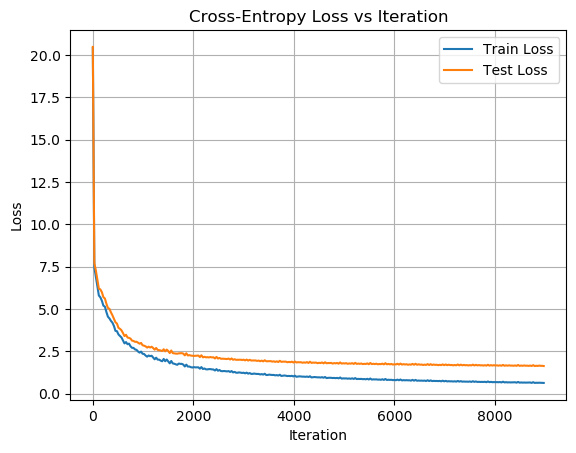

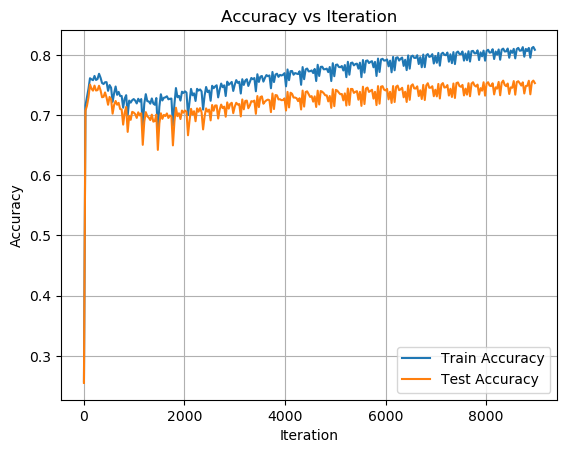

In [7]:
train_x = np.load('./fashion/train_x.npy') / 255.0
train_y = np.load('./fashion/train_y.npy')
test_x = np.load('./fashion/test_x.npy') / 255.0
test_y = np.load('./fashion/test_y.npy')

train_x = train_x.reshape(train_x.shape[0], -1)
test_x = test_x.reshape(test_x.shape[0], -1)

weights_data = np.load("weights.npy", allow_pickle=True).item()

weights = [weights_data[f"w{i+1}"] for i in range(3)]
biases  = [weights_data[f"b{i+1}"].reshape(1, -1) for i in range(3)]

train_losses, test_losses, train_accs, test_accs = train_model(train_x, train_y, test_x, test_y, weights, biases)

plot_learning_curves(train_losses, test_losses, train_accs, test_accs)

In [18]:
train_x.shape

(60000, 784)

## Problem 2

## Problem 3